In [112]:
import numpy as np
import lmdb
import numpy as np
import torch
import six
from torch.utils.data import Dataset
import json
from PIL import Image

import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from tqdm import trange

import albumentations as A
from albumentations import KeypointParams
from albumentations.pytorch import ToTensorV2

In [9]:
Path().cwd().parents[2]

PosixPath('/Users/nakagawaayato/compe/kaggle/mga')

In [71]:
# indices
env = lmdb.open(str(ROOT_DIR / 'data' / 'data0004' / 'lmdb'), max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
with env.begin(write=False) as txn:
    n_samples = int(txn.get('num-samples'.encode()))

indices = []
with env.begin(write=False) as txn:
    for i in range(n_samples):
        # load json
        label_key = f'label-{str(i+1).zfill(8)}'.encode()
        label = txn.get(label_key).decode('utf-8')
        json_dict = json.loads(label)
        if json_dict['chart-type'] != 'scatter':
            continue
        indices.append(i)

In [91]:
ROOT_DIR = Path().cwd().parents[2]
LMDB_DIR = ROOT_DIR / 'data' / 'data0004' / 'lmdb'

class cfg:
    input_size = 3
    output_size = 1
    img_h = 300
    img_w = 500
    heatmap_h = 80
    heatmap_w = 128
    sigma = 1

In [92]:
def tensor2arr(tensor_img):
    if len(tensor_img.shape) == 2:
        tensor_img = tensor_img.unsqueeze(0)
    return tensor_img.permute(1, 2, 0).numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])

In [156]:
def is_nan(value):
    """
    Check if a value is NaN (not a number).

    Args:
        value (int, float, str): The value to check

    Returns:
        bool: True if the value is NaN, False otherwise
    """
    return isinstance(value, float) and np.isnan(value)

In [157]:
# Lmdb Dataset
class MgaLmdbDataset(Dataset):
    def __init__(self, cfg, lmdb_dir, indices, transforms):
        super().__init__()
        self.cfg = cfg
        self.transforms = transforms
        self.indices = indices
        self.env = lmdb.open(str(lmdb_dir), max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        self.output_size = cfg.output_size
        self.sigma = cfg.sigma
        self.img_h, self.img_w = cfg.img_h, cfg.img_w
        self.heatmap_h, self.heatmap_w = cfg.heatmap_h, cfg.heatmap_w
        self.chart2point_name = {
            'scatter': 'scatter points',
            'line': 'lines',
            'dot': 'dot points',
            'vertical_bar': 'bars',
            'horizontal_bar': 'bars',
        }
    def _overlap_heatmap(self, heatmap, center, sigma):
        tmp_size = sigma * 6
        mu_x = int(center[0] + 0.5)
        mu_y = int(center[1] + 0.5)
        w, h = heatmap.shape[0], heatmap.shape[1]
        ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
        br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
        if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
            return heatmap
        size = 2 * tmp_size + 1
        x = np.arange(0, size, 1, np.float32)
        y = x[:, np.newaxis]
        x0 = y0 = size // 2
        g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
        g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
        g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
        img_x = max(0, ul[0]), min(br[0], h)
        img_y = max(0, ul[1]), min(br[1], w)
        heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
        heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
        g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
        return heatmap

    def _create_heatmap(self, joints):
        '''
            joints: [(x1, y1), (x2, y2), ...]
            heatmap: size: (hm_h, hm_w)
        '''
        heatmap = np.zeros((self.heatmap_h, self.heatmap_w), dtype=np.float32)
        for joint_id in range(len(joints)):
            heatmap = self._overlap_heatmap(heatmap, joints[joint_id], self.sigma)
        return heatmap

    def _count_n_points(self, json_dict):
        """
        Args:
            json_dict (Dict[str, Any]): ターゲットのdict
        Returns:
            gt_string (str): 入力となるプロンプト
        """
        n_points = 0

        for d in json_dict['data-series']:
            x = d["x"]
            y = d["y"]
            # Ignore nan values
            if is_nan(x) or is_nan(y):
                continue
            n_points += 1
        
        return n_points

    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        idx = self.indices[idx]
        with self.env.begin(write=False) as txn:
            # load image
            img_key = f'image-{str(idx+1).zfill(8)}'.encode()
            imgbuf = txn.get(img_key)

            # load json
            label_key = f'label-{str(idx+1).zfill(8)}'.encode()
            label = txn.get(label_key).decode('utf-8')
        
        # image
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)
        if self.cfg.input_size == 3:
            img = np.array(Image.open(buf).convert('RGB'))
        else:
            img = np.array(Image.open(buf).convert('L'))
        h, w, _ = img.shape
        
        # label
        json_dict = json.loads(label)
        chart_type = json_dict['chart-type']
        point_name = self.chart2point_name[chart_type]

        keypoints = []
        for dic in json_dict['visual-elements'][point_name][0]:
            x, y = dic['x'], dic['y']
            if x < 0 or y < 0 or x > w or y > h:
                continue
            keypoints.append([x, y])

        # kp_arr = np.array(keypoints)
        # kp_min = np.amin(kp_arr, 0)
        # if kp_min[0] < 0 or kp_min[1] < 0:
        #     # print(keypoints)
        #     print(json_dict['id'])

        transformed = self.transforms(image=img, keypoints=keypoints)
        img = transformed['image']
        keypoints = transformed['keypoints']
        
        if len(keypoints) != 0:
            keypoints_on_hm = np.array(keypoints) * \
                np.array([self.heatmap_w, self.heatmap_h]) / np.array([self.img_w, self.img_h])

            heatmap = self._create_heatmap(keypoints_on_hm)
        else:
            heatmap = np.zeros((self.heatmap_h, self.heatmap_w))
        img = torch.from_numpy(img).permute(2, 0, 1)
        heatmap = torch.from_numpy(heatmap)

        n_points = self._count_n_points(json_dict)

        return img, heatmap, n_points

In [158]:
def get_transforms():
    return A.Compose([
        A.Resize(300, 500),
        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ], keypoint_params=KeypointParams(format='xy'))

In [159]:
ds = MgaLmdbDataset(cfg, LMDB_DIR, indices, get_transforms())

In [160]:
img, hm, n_points = ds.__getitem__(3)

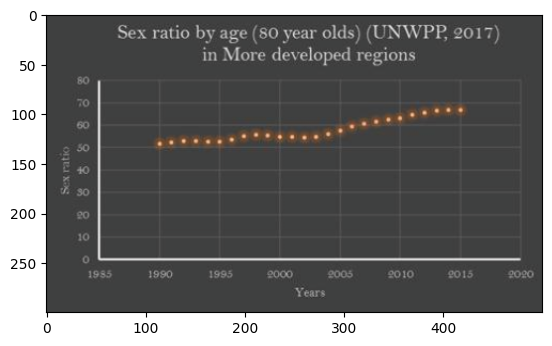

In [161]:
plt.imshow(tensor2arr(img))

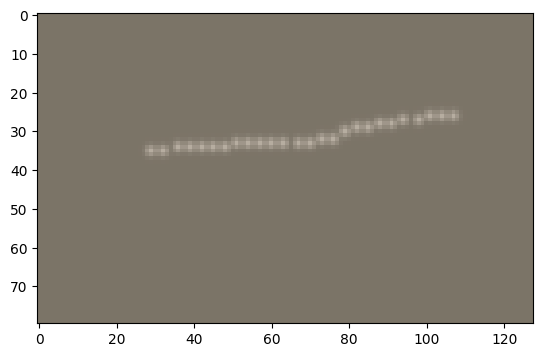

In [162]:
plt.imshow(tensor2arr(hm))

In [163]:
n_correct = 0
for i in trange(len(indices)):
    img, hm, n_points = ds.__getitem__(i)
    if torch.sum(hm > 0.7) == n_points:
        n_correct += 1
print(n_correct / len(indices))

100%|██████████| 11243/11243 [00:56<00:00, 200.50it/s]

0.9973316730410033
